<a href="https://colab.research.google.com/github/Ragdehl/Rakuten_py/blob/main/manu/XGBOOST_DELAY_LOOP_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import glob
import pandas as pd
from tqdm import tqdm
import numpy as np

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize
from datetime import datetime

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\utilisateur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
X = pd.read_csv('X_train_update.csv',index_col=0)

In [ ]:
y = pd.read_csv('Y_train_CVw08PX.csv',index_col=0)

In [ ]:
y['label'] = y['prdtypecode'].replace(y.prdtypecode.unique(), [*range(len(y.prdtypecode.unique()))]) ## permet de simplifier les N°  de classes

In [ ]:
# réalisation de la jointure des 2 colonnes texte du dataframe
headlines = []  #####
for row in range(0,len(X.index)):
    headlines.append(' '.join(str(x) for x in X.iloc[row,0:2]))

In [ ]:
df = pd.DataFrame({'Features': headlines})

In [ ]:
# ajout colonne label
df['label']=y['label']

In [ ]:
# Importer la classe train_test 
from sklearn.model_selection import train_test_split

# Séparer le jeu de données en données d'entraînement et données test 
X, X_valid, y, y_valid = train_test_split(df.Features, df.label,train_size=0.05, test_size=0.01)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print('Validation size is',y_train.size ,'test size is', y_test.size, 'and validation size is', y_valid.size)

Validation size is 3396 test size is 849 and validation size is 850


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfid = TfidfVectorizer(analyzer='word',tokenizer=word_tokenize,max_df=0.8, min_df=1, ngram_range=(1,2), binary=True) # max_df=0.8

X_train = tfid.fit_transform(X_train).todense()
X_test = tfid.transform(X_test).todense()
X_valid = tfid.transform(X_valid).todense()

In [ ]:
print(X_train[0], X_test[0], X_valid[0])

[[0. 0. 0. ... 0. 0. 0.]] [[0. 0. 0. ... 0. 0. 0.]] [[0. 0. 0. ... 0. 0. 0.]]


In [ ]:
import xgboost as xgb

In [ ]:
train = xgb.DMatrix(X_train,y_train)
test = xgb.DMatrix(X_test,y_test)
valid = xgb.DMatrix(X_valid,y_valid)

In [ ]:
params = {'booster':'gbtree', 'learning_rate': 0.5,'objective':'multi:softmax','num_class':27}

xgb1 = xgb.train(params = params,
                 dtrain = train,
                 num_boost_round= 100,
                 early_stopping_rounds= 5,
                 evals= [(train, 'train'), (test, 'eval')])


[22:07:07] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-mlogloss:1.63368	eval-mlogloss:2.02296
[1]	train-mlogloss:1.31504	eval-mlogloss:1.84410
[2]	train-mlogloss:1.10686	eval-mlogloss:1.73703
[3]	train-mlogloss:0.96705	eval-mlogloss:1.66437
[4]	train-mlogloss:0.85596	eval-mlogloss:1.62416
[5]	train-mlogloss:0.76820	eval-mlogloss:1.59303
[6]	train-mlogloss:0.69572	eval-mlogloss:1.56347
[7]	train-mlogloss:0.63599	eval-mlogloss:1.54768
[8]	train-mlogloss:0.58473	eval-mlogloss:1.52900
[9]	train-mlogloss:0.54190	eval-mlogloss:1.51560
[10]	train-mlogloss:0.50519	eval-mlogloss:1.51261
[11]	train-mlogloss:0.47377	eval-mlogloss:1.51371
[12]	train-mlogloss:0.44410	eval-mlogloss:1.51135
[13]	train-mlogloss:0.41818	eval-mlogloss:1.51511
[14]	train-mlogloss:0.39498	eval-mlogloss:1.51764
[15]	tra

In [ ]:
preds = pd.Series(xgb1.predict(valid).astype(int))
import numpy as np

y_valid.index = np.arange(0,len(y_valid))
y_valid

pd.crosstab(preds,y_valid)

label,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
row_0,,,,,,,,,,,,,,,,,,,,,
0,15,1,0,3,1,1,1,0,5,0,...,0,0,2,1,0,0,0,0,2,0
1,0,36,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,5,0,0,0,0,0,0,0,...,0,4,0,0,0,0,0,0,0,0
3,0,0,1,25,0,0,1,2,4,0,...,3,0,0,4,2,1,0,1,0,0
4,11,7,3,2,23,2,1,0,2,2,...,1,10,0,8,1,1,0,2,0,0
5,0,0,0,1,0,25,0,3,1,1,...,1,0,0,0,1,0,0,1,1,1
6,0,0,0,1,0,0,12,3,0,1,...,0,0,0,0,0,0,0,2,0,0
7,0,0,0,1,0,0,1,37,1,2,...,6,0,0,0,1,0,0,0,1,0
8,0,0,0,1,0,0,0,1,5,1,...,0,1,0,0,0,0,0,0,0,0


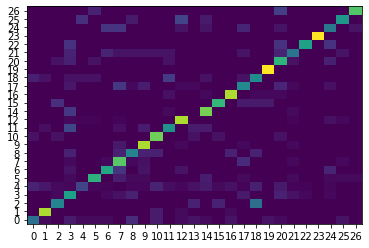

In [ ]:
import matplotlib.pyplot as plt

df = pd.crosstab(preds,y_valid)
somme = df.apply(np.sum,axis=1)

#ponderation par ligne
df = df.apply(lambda cell: cell/somme[cell.index])

plt.pcolor(df)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.show()

from sklearn.model_selection import GridSearchCV
import xgboost as xgb
learning_rate = [0.1, 0.5, 1]
#estimators = [50,100,200]

params = {'learning_rate': learning_rate} #,'n_estimators': estimators}
xgb_model = xgb.XGBClassifier()
gridCV = GridSearchCV(xgb_model,params,scoring='accuracy',cv=3,return_train_score=True, verbose = 2,n_jobs=-1)

gridCV.fit(X_train,y_train)
